# Automated Feature Engineering with Featuretools

_Automated feature engineering aims to help the data scientist by automatically creating many candidate features out of a dataset from which the best can be selected and used for training._ In this notebook we use Featuretools (TODO - LINK). Featuretools which is designed to generate features relational datasets. Let's use Featureools to engineer features from the Home Credit data set.

In [108]:
from quilt.data.avare import homecredit
import featuretools as ft
import pandas as pd
pd.set_option('display.max_columns', 125)

In [12]:
# get a list of all files in the repo
[*homecredit._keys()]

['POS_CASH_balance',
 'application_train',
 'bureau',
 'bureau_balance',
 'credit_card_balance',
 'installments_payments',
 'previous_application']

## Featuretools Entities and Relations

To use Featuretools, we must encode the data types for each table and relationships among the tables. The tables and relationships are depicted here:

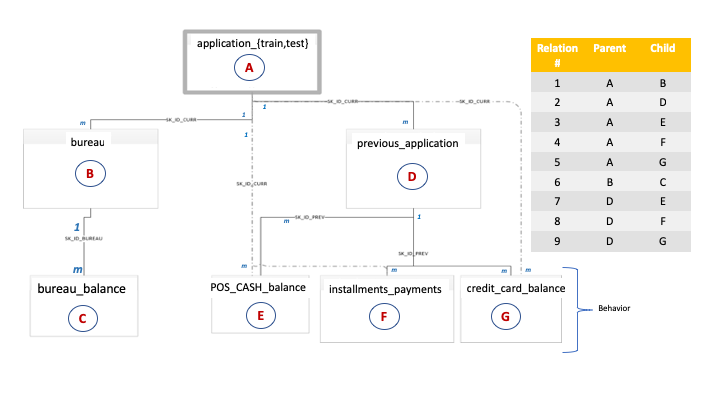

## Load Tables

* Quilt nodes are iterable: https://docs.quiltdata.com/api/api-python#enumerate-package-contents
* Since our tables are in a package root, our data nodes are accessed directly by iterating over the package object

In [128]:
frames = {}
for key, val in homecredit._items():
    frames[key] = val
 
print(frames.keys())

dict_keys(['POS_CASH_balance', 'application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'installments_payments', 'previous_application'])


## Load Data Types for Each Table

In [229]:
homecredit_descr = pd.read_excel('data/HomeCredit_columns_description.xlsx', sheet_name='Sheet1',usecols=[1,2,3])
homecredit_descr.head()

,Table,Row,Type
0,application_{train|test}.csv,SK_ID_CURR,ID
1,application_{train|test}.csv,TARGET,TARGET
2,application_{train|test}.csv,NAME_CONTRACT_TYPE,cat
3,application_{train|test}.csv,CODE_GENDER,cat
4,application_{train|test}.csv,FLAG_OWN_CAR,cat


In [230]:
type_dict = {}
files = homecredit_descr.Table.unique()
print(files)
file = 'application_{train|test}.csv'
atype = 'cat'
cols = [*homecredit_descr.query('(Table == @file) and (Type == @atype)').Row.values]
type_dict = {file: {atype: cols}}

['application_{train|test}.csv' 'bureau.csv' 'bureau_balance.csv'
 'POS_CASH_balance.csv' 'credit_card_balance.csv'
 'previous_application.csv' 'installments_payments.csv']


In [234]:
# get the names for given type and file
def homecredit_dtypes(df, filename, dtype):
    files = {'application_train':'application_{train|test}.csv', 'application_test':'application_{train|test}.csv'}
    dtypes = {'categorical' : 'cat', 'numerical' : 'num'}
    file = files[filename]
    atype = dtypes[dtype]
    cols = [*df.query('(Table == @file) and (Type == @atype)').Row.values]
    return cols


res = homecredit_dtypes(homecredit_descr, 'application_train', 'categorical')
print(len(res))

resn = homecredit_dtypes(homecredit_descr, 'application_train', 'numerical')
print(len(resn))
51+69

51
69


120

In [129]:
es = ft.EntitySet(id="application")

In [201]:
categorical_features = ['WALLSMATERIAL_MODE','EMERGENCYSTATE_MODE','FONDKAPREMONT_MODE']
numerical_features=frames['application_train']().columns.difference(categorical_features).values.tolist()

print(len(numerical_features))
def variable_types_dictionary(lst, featuretool_type):
    fttypes = {'categorical': 'ft.variable_types.Categorical','numerical': 'ft.variable_types.Numeric'}
    atype = fttypes[featuretool_type]
    str = []
    str.append('{')
    comma = ""
    for l in lst:
        str.append(comma + '\"' + l + '\": ' + atype) # TODO: use template
        comma = ","
    str.append('}') 
    res = eval(''.join(str))
    return res
       
#application_cat = variable_types_dictionary(categorical_features, 'categorical')
application_num = variable_types_dictionary(numerical_features, 'numerical')
print(application_num)
#application_types = {**application_cat, **application_num} 

print(application_types)


119
{'AMT_ANNUITY': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_CREDIT': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_GOODS_PRICE': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_INCOME_TOTAL': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_DAY': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_HOUR': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_MON': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_QRT': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_WEEK': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_YEAR': <class 'featuretools.variable_types.variable.Numeric'>, 'APARTMENTS_AVG': <class 'featuretools.variable_types.variable.Numeric'>, 'APARTMENTS_MEDI': <class 'featuretools.variable_types.variable.Numeric'>, 'APARTMENTS_MODE': <class 'featuretools.v

{'AMT_ANNUITY': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_CREDIT': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_GOODS_PRICE': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_INCOME_TOTAL': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_DAY': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_HOUR': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_MON': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_QRT': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_WEEK': <class 'featuretools.variable_types.variable.Numeric'>, 'AMT_REQ_CREDIT_BUREAU_YEAR': <class 'featuretools.variable_types.variable.Numeric'>, 'APARTMENTS_AVG': <class 'featuretools.variable_types.variable.Numeric'>, 'APARTMENTS_MEDI': <class 'featuretools.variable_types.variable.Numeric'>, 'APARTMENTS_MODE': <class 'featuretools.varia

In [107]:
es = es.entity_from_dataframe(dataframe=frames['application_train'](),
                              entity_id='application_train',
                              index='SK_ID_CURR',
                              variable_types={#"EOS_Acct": ft.variable_types.Id, 
                                        "Responsible": ft.variable_types.Categorical, 
                                        "Tradeline_Type": ft.variable_types.Categorical,
                                        "Date_Reported": ft.variable_types.Datetime,
                                        "Subscriber_Code": ft.variable_types.Categorical,
                                        "Industry_Type": ft.variable_types.Categorical,
                                        "Tradeline_Usage": ft.variable_types.Categorical,
                                        "Date_Opened": ft.variable_types.Datetime,
                                        "Trade_Ending_Cd": ft.variable_types.Categorical,
                                        "Term_Duration": ft.variable_types.Numeric,
                                        "Manner_Of_Pmt_Dte": ft.variable_types.Datetime,
                                        "Manner_Of_Payment": ft.variable_types.Categorical,
                                        "History_Reviewed": ft.variable_types.Numeric,
                                        "Delinquent_Payments": ft.variable_types.Numeric,
                                        "Late_30_Days": ft.variable_types.Numeric,
                                        "Late_60_Days": ft.variable_types.Numeric,
                                        "Late_90_Days": ft.variable_types.Numeric,
                                        "Indicator_Code_1": ft.variable_types.Categorical,
                                        "Subject_Type": ft.variable_types.Categorical})

POS_CASH_balance
   SK_ID_PREV  SK_ID_CURR  MONTHS_BALANCE  CNT_INSTALMENT  \
0     1803195      182943             -31            48.0   

   CNT_INSTALMENT_FUTURE NAME_CONTRACT_STATUS  SK_DPD  SK_DPD_DEF  
0                   45.0               Active       0           0  
application_train
   SK_ID_CURR  TARGET NAME_CONTRACT_TYPE CODE_GENDER FLAG_OWN_CAR  \
0      100002       1         Cash loans           M            N   

  FLAG_OWN_REALTY  CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  \
0               Y             0          202500.0    406597.5      24700.5   

   AMT_GOODS_PRICE NAME_TYPE_SUITE NAME_INCOME_TYPE  \
0         351000.0   Unaccompanied          Working   

             NAME_EDUCATION_TYPE    NAME_FAMILY_STATUS  NAME_HOUSING_TYPE  \
0  Secondary / secondary special  Single / not married  House / apartment   

   REGION_POPULATION_RELATIVE  DAYS_BIRTH  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018801       -9461           -637         

In [ ]:
entities = {
    "customers" : (customers_df, "customer_id"),
    "sessions" : (sessions_df, "session_id", "session_start"),
    "transactions" : (transactions_df, "transaction_id", "transaction_time")
}


In [19]:
#homecredit.application_train().query('SK_ID_CURR == 380361')
homecredit.application_train().head(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [40]:
homecredit.bureau().query('SK_ID_CURR == 380361')

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
768,380361,5715448,Active,currency 1,-820,0,31069.0,NaN,NaN,0,67500.0,0.0,67500.0,0.0,Credit card,-183,0.0
769,380361,5715449,Active,currency 1,-357,0,1119.0,NaN,NaN,0,45000.0,0.0,45000.0,0.0,Credit card,-130,2691.0
770,380361,5715451,Closed,currency 1,-917,0,-187.0,-759.0,NaN,0,74439.0,0.0,0.0,0.0,Consumer credit,-748,0.0
771,380361,5715452,Closed,currency 1,-993,0,31039.0,-831.0,NaN,0,315000.0,0.0,0.0,0.0,Credit card,-818,0.0
772,380361,5715453,Closed,currency 1,-1146,0,681.0,-780.0,NaN,0,2025000.0,0.0,0.0,0.0,Consumer credit,-769,0.0
773,380361,5715454,Closed,currency 1,-1622,0,-1074.0,-1073.0,NaN,0,540000.0,0.0,0.0,0.0,Consumer credit,-1006,0.0
774,380361,5715455,Closed,currency 1,-2631,0,-804.0,-1096.0,NaN,0,2205000.0,0.0,0.0,0.0,Car loan,-944,NaN
775,380361,5715456,Closed,currency 1,-1449,0,-1084.0,-1267.0,NaN,0,60480.0,0.0,0.0,0.0,Consumer credit,-1259,NaN
776,380361,5715457,Active,currency 1,-222,0,874.0,NaN,NaN,0,202500.0,31594.5,0.0,0.0,Credit card,-18,0.0
777,380361,5715458,Closed,currency 1,-749,0,-111.0,-110.0,NaN,0,1267843.5,0.0,NaN,0.0,Consumer credit,-110,0.0


In [21]:
homecredit.previous_application().query('SK_ID_CURR == 380361').sort_values('SK_ID_PREV')

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
355891,1279489,380361,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,14,Y,1,NaN,NaN,NaN,XNA,Canceled,-268,XNA,XAP,None,Repeater,XNA,XNA,XNA,Credit and cash offices,-1,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1095765,1442773,380361,Cash loans,44793.270,1170000.0,1322896.5,NaN,1170000.0,SATURDAY,16,Y,1,NaN,NaN,NaN,XNA,Approved,-786,Cash through the bank,XAP,Unaccompanied,Refreshed,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,54.0,low_normal,Cash X-Sell: low,365243.0,-756.0,834.0,-726.0,-721.0,1.0
703832,1661043,380361,Cash loans,13114.980,112500.0,119925.0,0.0,112500.0,WEDNESDAY,15,Y,1,0.000000,NaN,NaN,XNA,Approved,-2588,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,100,XNA,12.0,high,Cash Street: high,365243.0,-2558.0,-2228.0,-2228.0,-2220.0,1.0
971473,1910156,380361,Consumer loans,1930.140,35374.5,42844.5,0.0,35374.5,TUESDAY,13,Y,1,0.000000,NaN,NaN,XAP,Approved,-489,Cash through the bank,XAP,None,Repeater,Audio/Video,POS,XNA,Country-wide,100,Consumer electronics,24.0,low_action,POS household without interest,365243.0,-458.0,232.0,-248.0,-246.0,0.0
353112,2104755,380361,Revolving loans,38250.000,0.0,765000.0,NaN,NaN,SATURDAY,16,Y,1,NaN,NaN,NaN,XAP,Approved,-786,XNA,XAP,None,Refreshed,XNA,Cards,x-sell,Credit and cash offices,-1,XNA,0.0,XNA,Card X-Sell,-772.0,-744.0,365243.0,-563.0,365243.0,0.0
1138587,2653129,380361,Cash loans,26242.425,360000.0,399915.0,0.0,360000.0,SATURDAY,17,Y,1,0.000000,NaN,NaN,XNA,Approved,-2319,Cash through the bank,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Credit and cash offices,100,XNA,24.0,middle,Cash Street: middle,365243.0,-2289.0,-1599.0,-1599.0,-1597.0,1.0
1526491,2837103,380361,Consumer loans,8362.170,135211.5,147415.5,13500.0,135211.5,THURSDAY,12,Y,1,0.091369,NaN,NaN,XAP,Approved,-74,Cash through the bank,XAP,Unaccompanied,Repeater,Audio/Video,POS,XNA,Country-wide,300,Consumer electronics,24.0,low_normal,POS household with interest,365243.0,-44.0,646.0,365243.0,365243.0,1.0


In [20]:
#homecredit.POS_CASH_balance().query('SK_ID_PREV == 1910156')
homecredit.POS_CASH_balance().query('SK_ID_CURR == 380361').sort_values('SK_ID_PREV')

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
983112,1442773,380361,-26,54.0,54.0,Active,0,0
6691075,1442773,380361,-24,2.0,0.0,Completed,0,0
3306608,1442773,380361,-25,54.0,53.0,Active,0,0
8239638,1661043,380361,-74,12.0,1.0,Active,0,0
9489963,1661043,380361,-81,12.0,8.0,Active,0,0
9489388,1661043,380361,-79,12.0,6.0,Active,0,0
7877204,1661043,380361,-83,12.0,10.0,Active,0,0
9270032,1661043,380361,-85,12.0,12.0,Active,0,0
9268007,1661043,380361,-80,12.0,7.0,Active,0,0
9267898,1661043,380361,-82,12.0,9.0,Active,0,0


In [36]:
homecredit.bureau_balance()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
5,5715448,-5,C
6,5715448,-6,C
7,5715448,-7,C
8,5715448,-8,C
9,5715448,-9,0
